In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set_style({'font.family':'sans-serif', 'font.sans-serif':'Arial'})
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
combo2_file = "/data5/deepro/ukbiobank/analysis/bmi_project/lifestyle_factors/data/results/tables/combo2_lf_gene.csv"
combo3_file = "/data5/deepro/ukbiobank/analysis/bmi_project/lifestyle_factors/data/results/tables/combo3.csv"
rarecomb_in_file = "/data5/deepro/ukbiobank/analysis/bmi_project/lifestyle_factors/data/meta_rarecomb_in.csv"
# the lifestyles of interest
lfs=["mental_health", "diet", "physical_activity"]
phenotypes_file = "/data5/UK_Biobank/bmi_project/combinations/all_combinations/sample_tables/white_british_samples_with_residuals.csv"
pheno_cases = "/data5/UK_Biobank/bmi_project/combinations/white_british/cases_controls/high_low_cases.txt"
gencode_file = '/data5/bx_reference/hg38/annotations/gene_annotations/GENCODE39/gencode.v39.parsed.genes.tsv'
save_dir = "/data5/deepro/ukbiobank/analysis/bmi_project/lifestyle_factors/data/results/figures"

In [3]:
gencode = pd.read_csv(gencode_file, sep='\t', low_memory=False)
gencode["gene_id_stripped"] = gencode["gene_id"].str.split(".", expand=True)[0]
gene_symbol_dict = dict(zip(gencode.gene_id_stripped, gencode.gene_name))

In [4]:
def get_profiles_enriched_combos(combo_file, lf, cases, item_2_type, ncombos):
    combinations_df = pd.read_csv(combo_file, low_memory=False)
    lf_df = combinations_df.loc[combinations_df.eval("|".join([f"Item_{i}.str.contains('{lf}')" for i in range(1, ncombos + 1)]))]
    lf_df = lf_df.loc[lf_df.Item_2_type==item_2_type]
    enriched_combos = lf_df.loc[:, [f"Item_{c}" for c in range(1, ncombos+1)]].values
    enriched_combos_set = set(enriched_combos.flatten()).union(set(enriched_combos.flatten()))
    cond = " | ".join(["(" + " & ".join([f"({c} == 1)" for c in ec_i]) + ")" for ec_i in enriched_combos])
    gene_columns_to_use = [c for c in enriched_combos_set if "_ENSG" in c]
    lifestyle_columns_to_use = [c for c in enriched_combos_set if "_ENSG" not in c]
    # get wes data on samples with these gene columns
    rarecomb_df = pd.read_csv(rarecomb_in_file, low_memory=False, usecols=["Sample_Name"] + list(enriched_combos_set), index_col=0)
    # only keep the cases
    cases_list = []
    with open(cases, "r") as f:
        for lines in f:
            cases_list.append(int(lines.strip()))
    rarecomb_df = rarecomb_df.loc[rarecomb_df.index.isin(cases_list)]
    # get the bmi of these samples
    phenotypes_df = pd.read_csv(phenotypes_file, low_memory=False, usecols=["eid", "bmi"], index_col=0, dtype={"eid": str, "bmi": np.float64})
    profile_df = rarecomb_df.merge(phenotypes_df, left_index=True, right_index=True)
    selected_profile_df = profile_df.loc[profile_df.eval(cond)]
    return selected_profile_df, gene_columns_to_use, lifestyle_columns_to_use

In [9]:
def edit_profile_df_colnames(colnames, gene_symbol_dict):
    new_gene_cols = []
    new_lf_cols = []
    new_colnames = []
    for c in colnames:
        if c.startswith("Input_ENSG"):
            item_name = gene_symbol_dict[c.replace("Input_", "")]
            new_gene_cols.append(item_name)
        else:
            item_name = c.replace("Input_", "")
            new_lf_cols.append(item_name)
        new_colnames.append(item_name)
    return new_colnames, new_gene_cols, new_lf_cols 

def save_heatmap(selected_profile_df, gene_cols, lf_cols, save_file, figsize, lw):
    selected_profile_df = selected_profile_df.loc[:, (selected_profile_df!=0).any(axis=0)]
    gene_cols = [c for c in gene_cols if c in selected_profile_df.columns]
    lf_cols = [c for c in lf_cols if c in selected_profile_df.columns]
    selected_profile_df = selected_profile_df.sort_values(gene_cols, ascending=False)
    pdf_store = PdfPages(save_file)
    fig, ax = plt.subplots(1,2, figsize=figsize, gridspec_kw={'width_ratios': [len(gene_cols), len(lf_cols)]})
    g1 = sns.heatmap(
        data=selected_profile_df.loc[:, gene_cols], 
        linewidths=lw,
        linecolor="silver", 
        cbar=False,
        cmap=["w", "r"],
        ax=ax[0],
        yticklabels=False,
        square=False,
        )
    g2 = sns.heatmap(
        data=selected_profile_df.loc[:, lf_cols], 
        linewidths=lw,
        linecolor="silver", 
        cbar=False,
        cmap=["w", "r"],
        ax=ax[1],
        yticklabels=False,
        square=False,
        )
    pdf_store.savefig(fig, bbox_inches='tight')
    pdf_store.close()
    return

# mental health

## Get profile

In [6]:
mh_selected_profile_df, mh_gene_cols, mh_lf_cols  = get_profiles_enriched_combos(combo3_file, "mental_health", pheno_cases, "gene", 3)

## Edit column names

In [7]:
mh_selected_profile_df_colnames, mh_gene_cols, mh_lf_cols = edit_profile_df_colnames(mh_selected_profile_df.columns, gene_symbol_dict)
mh_selected_profile_df.columns = mh_selected_profile_df_colnames
mh_lf_cols.remove("bmi")

## Plot heatmap

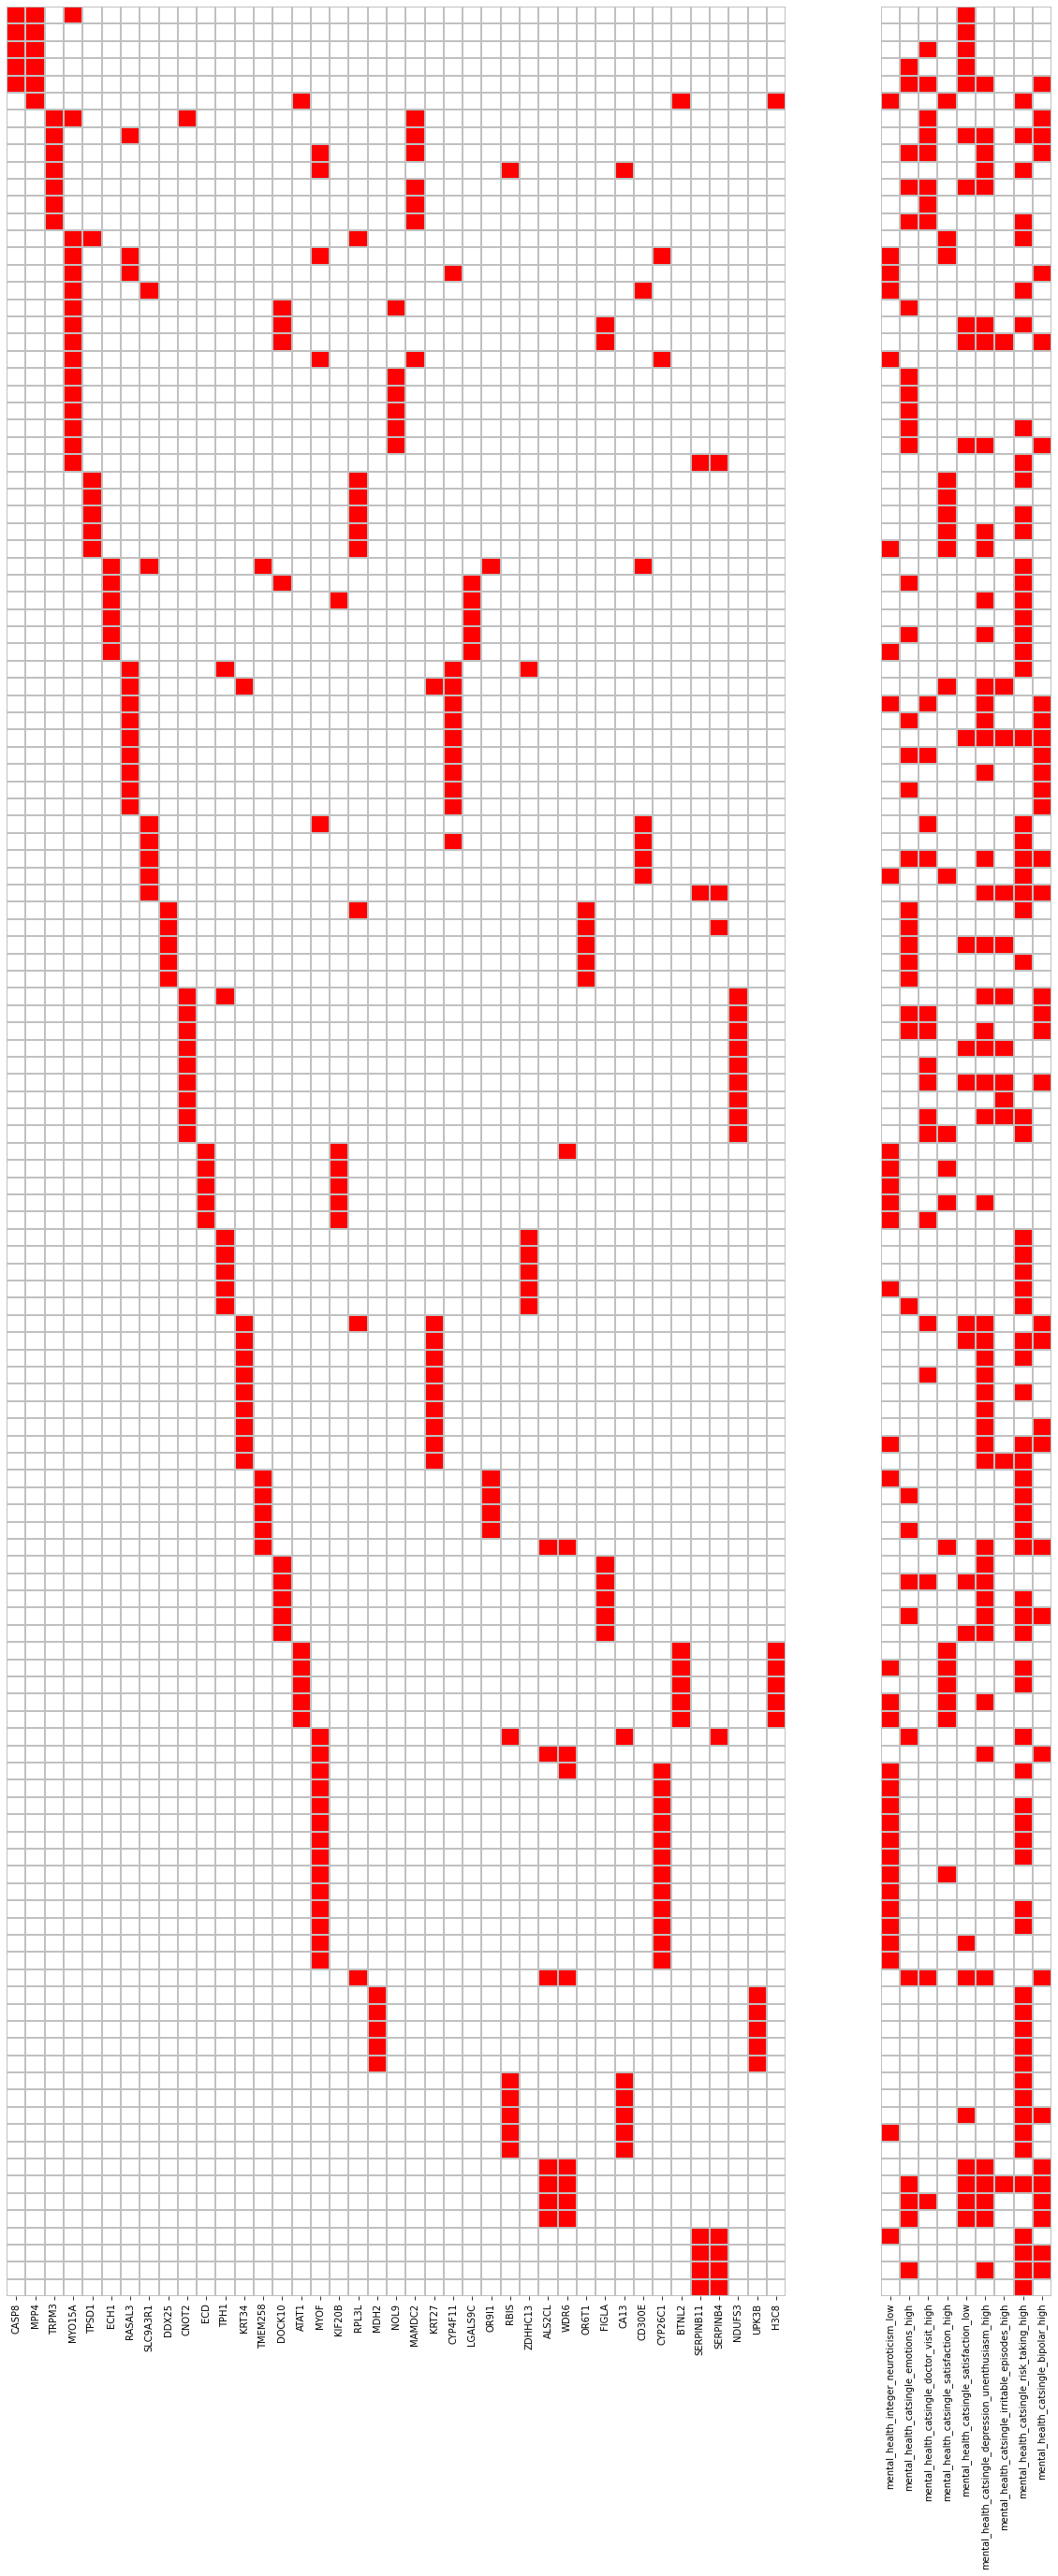

In [10]:
mh_save_file = "/data5/deepro/ukbiobank/analysis/bmi_project/lifestyle_factors/data/results/figures/mental_health_lf_gene_gene.pdf"
save_heatmap(mh_selected_profile_df, mh_gene_cols, mh_lf_cols, mh_save_file, (20, 45), 1.5)

# diet

## Get profile

In [11]:
d_selected_profile_df, d_gene_cols, d_lf_cols = get_profiles_enriched_combos(combo3_file, "diet", pheno_cases, "gene", 3)

## Edit column names

In [12]:
d_selected_profile_df_colnames, d_gene_cols, d_lf_cols = edit_profile_df_colnames(d_selected_profile_df.columns, gene_symbol_dict)
d_selected_profile_df.columns = d_selected_profile_df_colnames
d_lf_cols.remove("bmi")

## Get heatmap

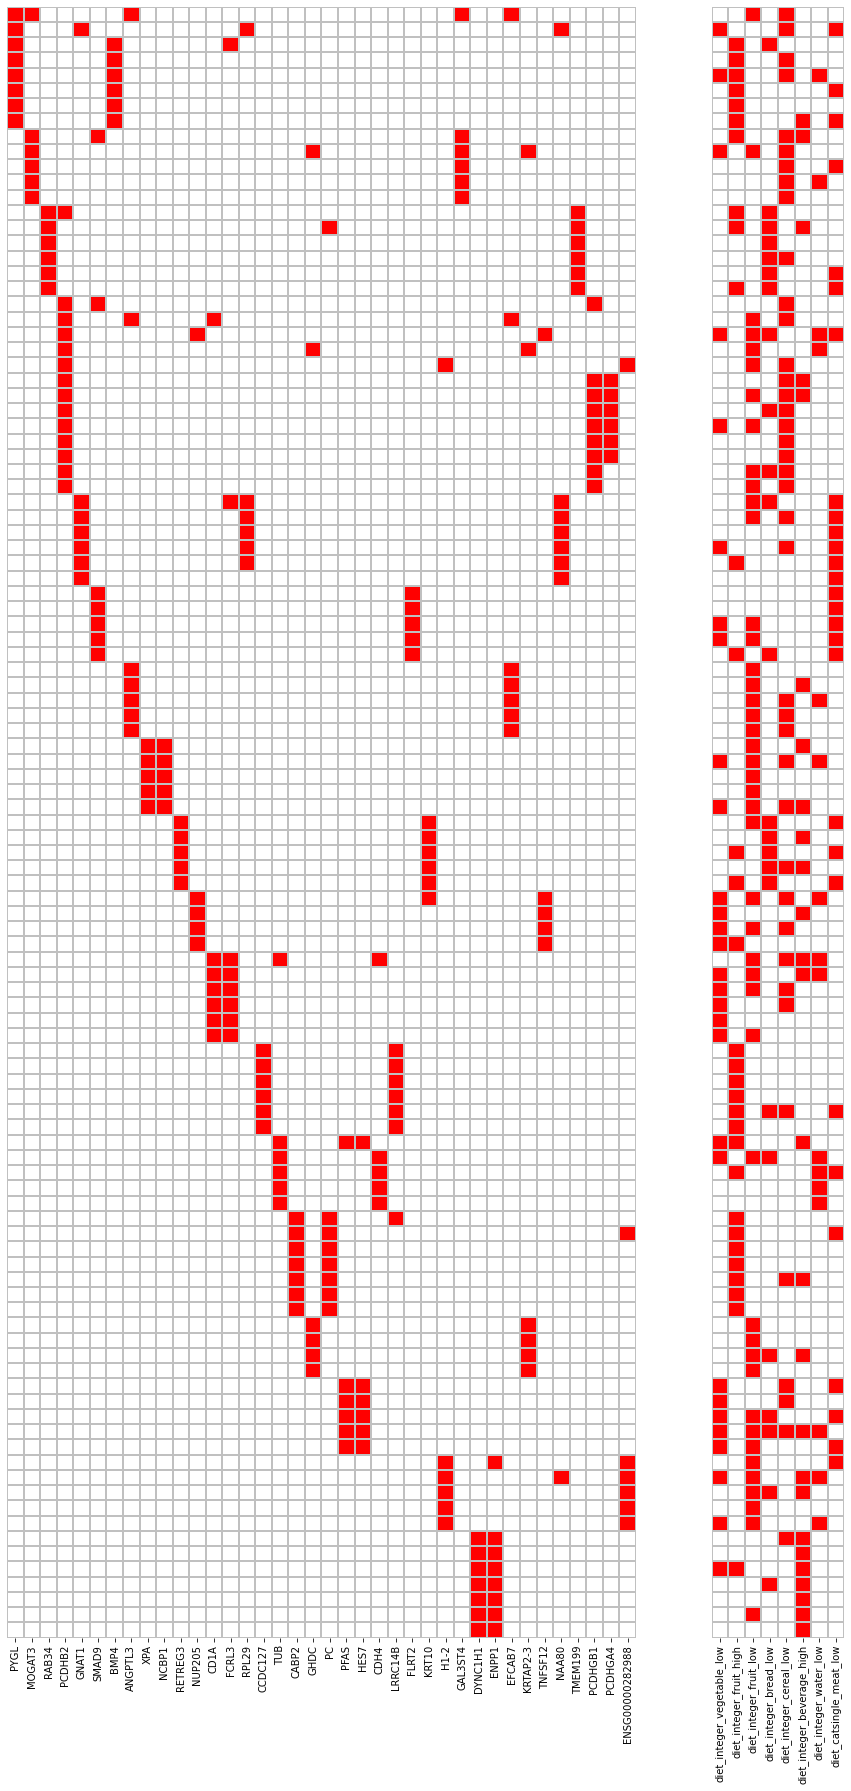

In [13]:
d_save_file = "/data5/deepro/ukbiobank/analysis/bmi_project/lifestyle_factors/data/results/figures/diet_lf_gene_gene.pdf"
save_heatmap(d_selected_profile_df, d_gene_cols, d_lf_cols, d_save_file, (15, 30), 1.5)

# physical activity

## Get profile

In [14]:
pa_selected_profile_df, pa_gene_cols, pa_lf_cols = get_profiles_enriched_combos(combo3_file, "physical_activity", pheno_cases, "gene", 3)

## Edit column names

In [15]:
pa_selected_profile_df_colnames, pa_gene_cols, pa_lf_cols = edit_profile_df_colnames(pa_selected_profile_df.columns, gene_symbol_dict)
pa_selected_profile_df.columns = pa_selected_profile_df_colnames
pa_lf_cols.remove("bmi")

## Plot heatmap

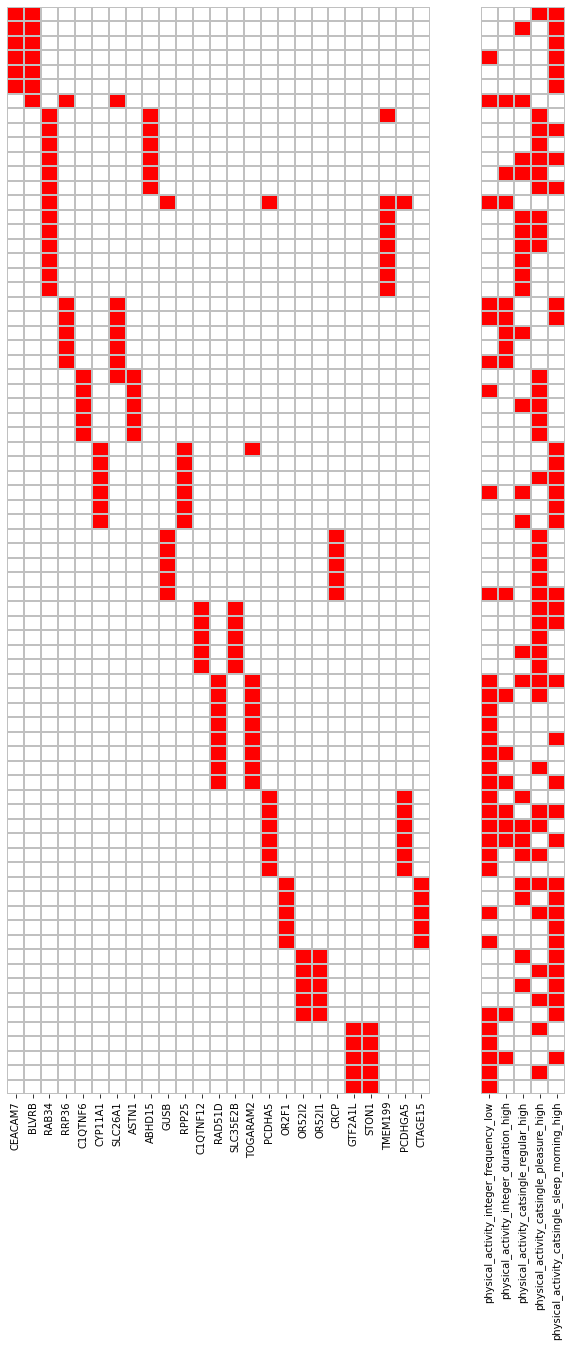

In [16]:
pa_save_file = "/data5/deepro/ukbiobank/analysis/bmi_project/lifestyle_factors/data/results/figures/physical_activity_lf_gene_gene.pdf"
save_heatmap(pa_selected_profile_df, pa_gene_cols, pa_lf_cols, pa_save_file, (10, 20), 1.5)